# **Time Series Data**

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

In [75]:
print(df)

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
...          ...
1990-12-27  14.0
1990-12-28  13.6
1990-12-29  13.5
1990-12-30  15.7
1990-12-31  13.0

[3650 rows x 1 columns]


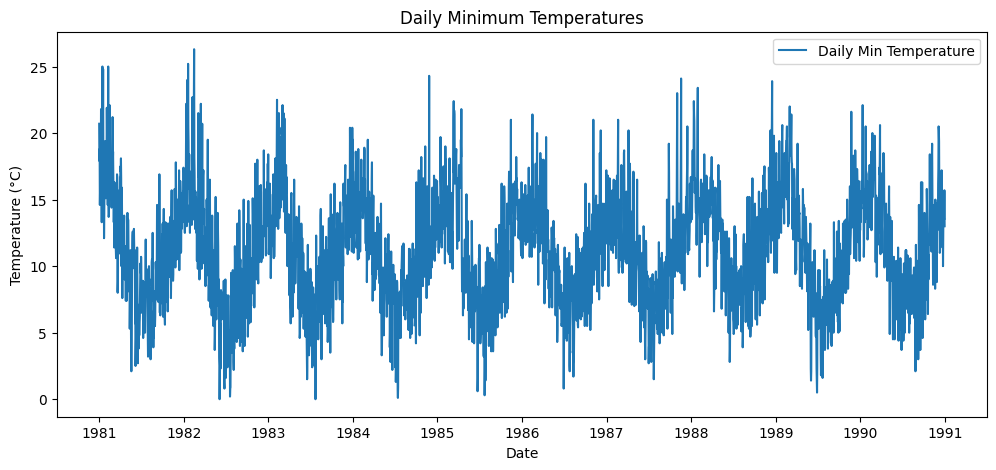

In [76]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Temp'], label='Daily Min Temperature')
plt.title("Daily Minimum Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

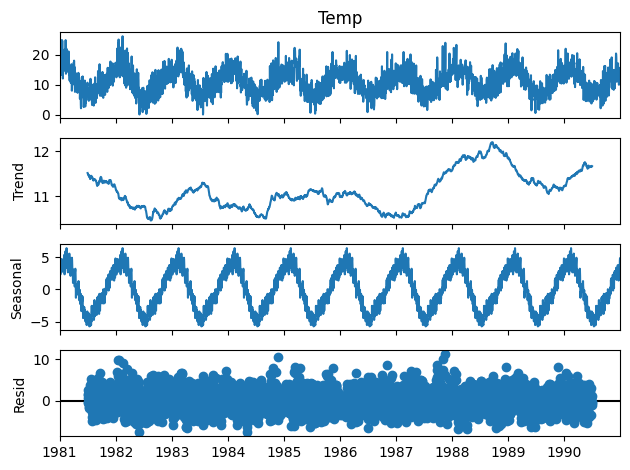

In [77]:
# Decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Temp'], model='additive', period=365)
decomposition.plot()
plt.show()

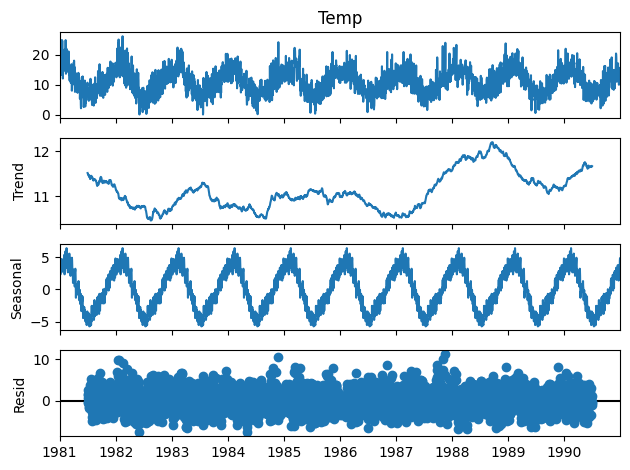

In [78]:
# Decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Temp'], model='Multiplicative', period=365)
decomposition.plot()
plt.show()

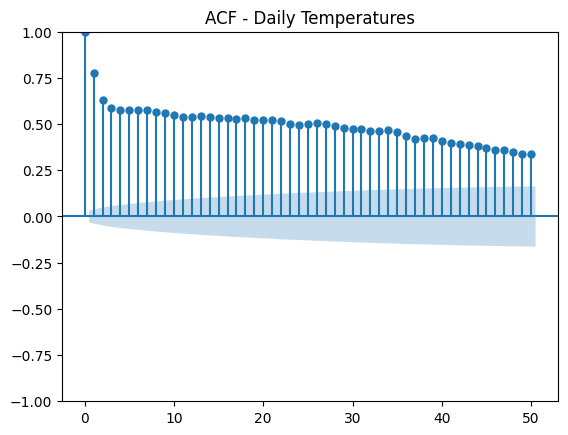

In [79]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Temp'], lags=50)
plt.title("ACF - Daily Temperatures")
plt.show()

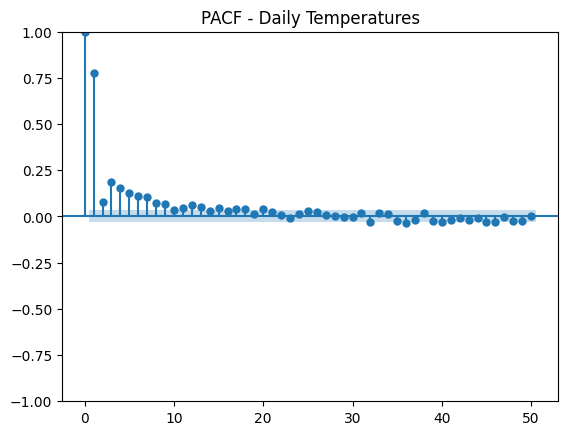

In [80]:
#plot PACF
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['Temp'], lags=50)
plt.title("PACF - Daily Temperatures")
plt.show()

# **Moving Average & Standard Deviation**

In [81]:
df['SMA_30'] = df['Temp'].rolling(window=30).mean()
df['EMA_30'] = df['Temp'].ewm(span=30, adjust=False).mean()

In [82]:
df['Rolling_Std_30'] = df['Temp'].rolling(window=30).std()

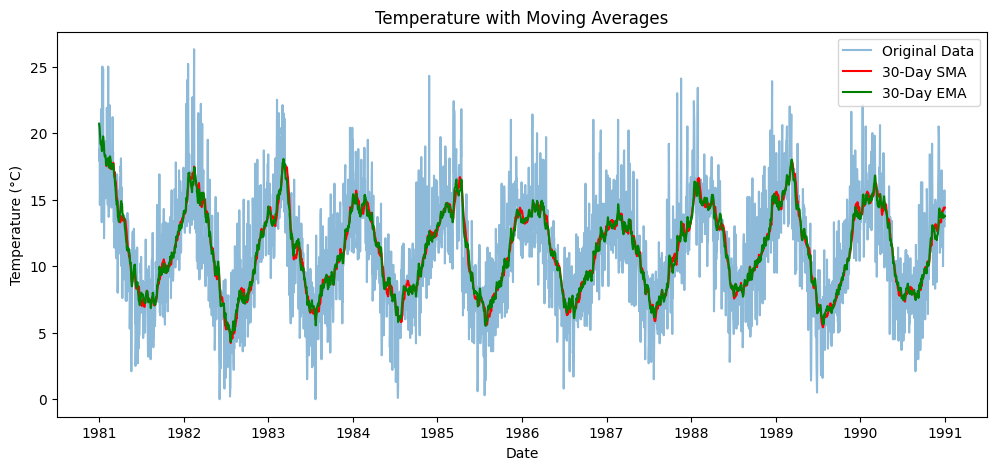

In [83]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Temp'], label='Original Data', alpha=0.5) #alpha = darkness of graph
plt.plot(df.index, df['SMA_30'], label='30-Day SMA', color='red')
plt.plot(df.index, df['EMA_30'], label='30-Day EMA', color='green')
plt.title("Temperature with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

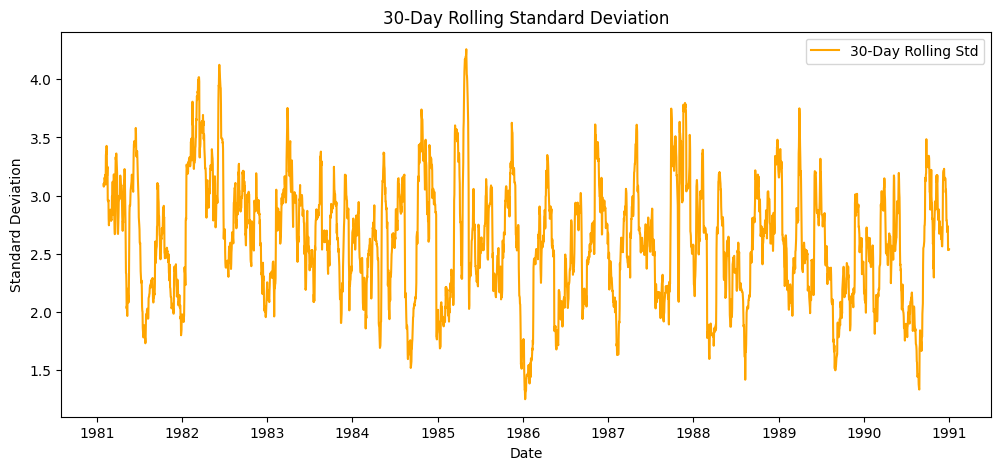

In [84]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Rolling_Std_30'], label='30-Day Rolling Std', color='orange')
plt.title("30-Day Rolling Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.legend()
plt.show()

# **Outlier Detection using Z-Score and IQR**

In [85]:
import numpy as np
from scipy.stats import zscore

In [86]:
window = 30
df['Rolling_Mean'] = df['Temp'].rolling(window=window).mean()
df['Rolling_Std'] = df['Temp'].rolling(window=window).std()


In [87]:
df['Rolling_Z_Score'] = (df['Temp'] - df['Rolling_Mean']) / df['Rolling_Std']
#print(df)

df['Z_Outlier'] = df['Rolling_Z_Score'].abs() > 2

In [88]:
Q1 = df['Temp'].quantile(0.25)
Q3 = df['Temp'].quantile(0.75)
#print(Q1, Q3)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['IQR_Outlier'] = (df['Temp'] < lower_bound) | (df['Temp'] > upper_bound)
#print(df)

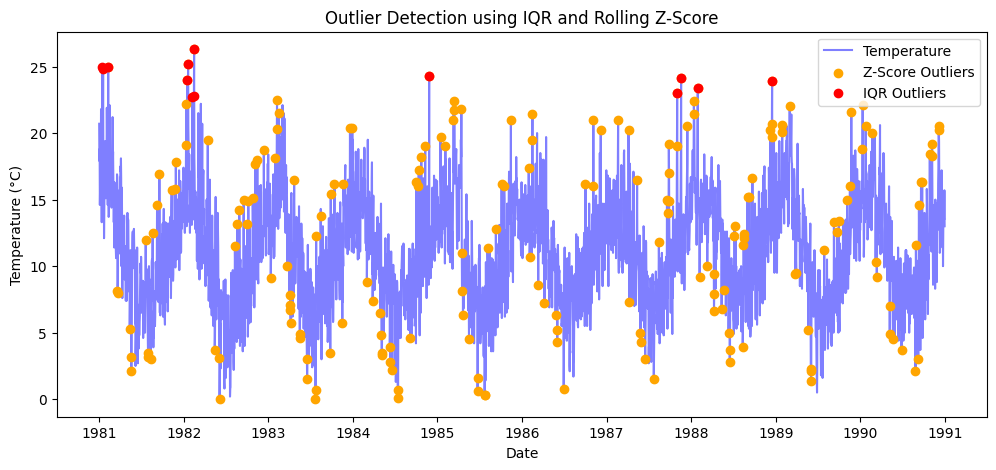

In [89]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Temp'], label="Temperature", color="blue", alpha=0.5)

# Plot Z-score outliers
plt.scatter(df.index[df['Z_Outlier']], df['Temp'][df['Z_Outlier']],
            color="orange", label="Z-Score Outliers", zorder=3)

# Plot IQR outliers
plt.scatter(df.index[df['IQR_Outlier']], df['Temp'][df['IQR_Outlier']],
            color="red", label="IQR Outliers", zorder=3)

plt.title("Outlier Detection using IQR and Rolling Z-Score")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


# **Time Series Specific Outliers**

In [90]:
# Rolling Window Outlier Detection (reuse window of 30 days)
df['Rolling_Z_Score'] = (df['Temp'] - df['Rolling_Mean']) / df['Rolling_Std']
df['Rolling_Outlier'] = df['Rolling_Z_Score'].abs() > 2

In [91]:
#  we simulate a weekly seasonal effect.
df['Seasonal_Mean'] = df['Temp'].shift(7).rolling(window=4, center=True).mean()
df['Seasonal_Std'] = df['Temp'].shift(7).rolling(window=4, center=True).std()
df['Seasonal_Z_Score'] = (df['Temp'] - df['Seasonal_Mean']) / df['Seasonal_Std']
df['Seasonal_Outlier'] = df['Seasonal_Z_Score'].abs() > 2

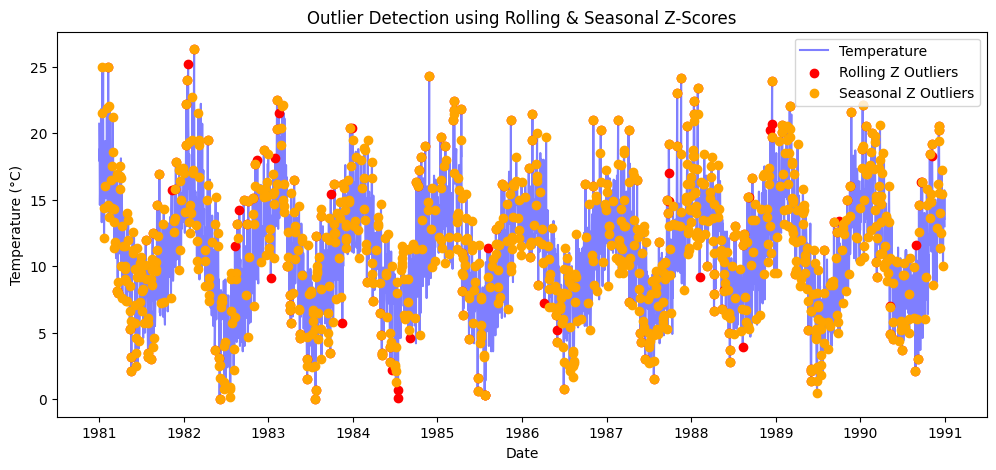

In [92]:
# Plot both Rolling and Seasonal outliers
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Temp'], label="Temperature", color="blue", alpha=0.5)

# Rolling Z-score outliers
plt.scatter(df.index[df['Rolling_Outlier']], df['Temp'][df['Rolling_Outlier']],
            color="red", label="Rolling Z Outliers", zorder=3)

# Seasonal Z-score outliers
plt.scatter(df.index[df['Seasonal_Outlier']], df['Temp'][df['Seasonal_Outlier']],
            color="orange", label="Seasonal Z Outliers", zorder=3)

plt.title("Outlier Detection using Rolling & Seasonal Z-Scores")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


# **Isolation Forest for Anomaly Detection**

In [93]:
from sklearn.ensemble import IsolationForest

In [94]:
df['Lag_1'] = df['Temp'].shift(1)
df = df.dropna()

In [106]:
df['DayOfWeek'] = df.index.dayofweek #Adds a column showing the day of the week. This helps capture weekly patterns in temperature

In [96]:
features = ['Temp', 'Lag_1', 'DayOfWeek']
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['Iso_Forest_Pred'] = model.fit_predict(df[features])
df['Iso_Anomaly'] = df['Iso_Forest_Pred'] == -1

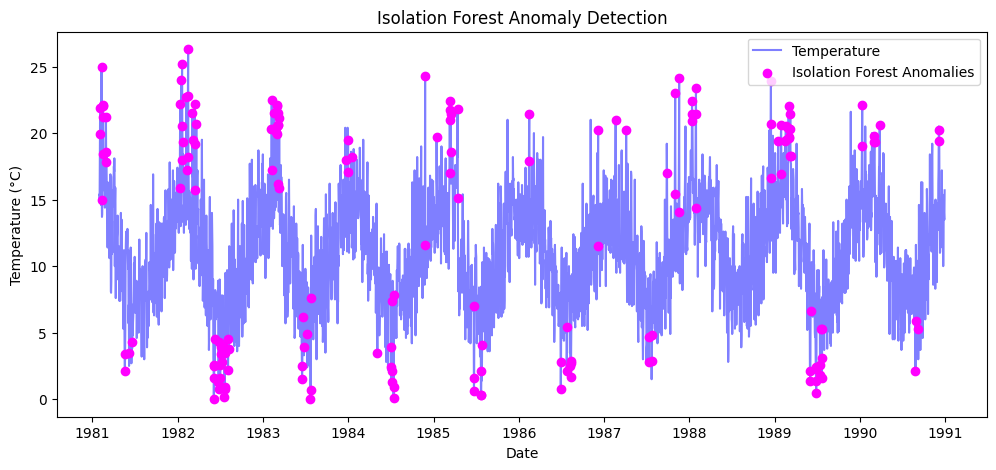

In [97]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Temp'], label="Temperature", color="blue", alpha=0.5)
plt.scatter(df.index[df['Iso_Anomaly']], df['Temp'][df['Iso_Anomaly']],
            color="magenta", label="Isolation Forest Anomalies", zorder=3)
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# **Neighborhood Comparison Methods**

In [98]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [100]:
df_nn = df[['Temp', 'Lag_1']].copy().dropna()

In [102]:
# ---- k-NN based distance anomaly detection ----
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(df_nn)
distances, _ = nbrs.kneighbors(df_nn)
# Use the distance to the 5th neighbor as an anomaly score
df_nn['knn_score'] = distances[:, -1]

# Flag anomalies based on a high score (using the 95th percentile)
threshold = np.percentile(df_nn['knn_score'], 95)
df_nn['knn_anomaly'] = df_nn['knn_score'] > threshold

In [103]:
#  LOF (Local Outlier Factor)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df_nn['lof_pred'] = lof.fit_predict(df_nn[['Temp', 'Lag_1']])
df_nn['lof_anomaly'] = df_nn['lof_pred'] == -1

In [104]:
# ---- DBSCAN ----
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_nn['dbscan_label'] = dbscan.fit_predict(df_nn[['Temp', 'Lag_1']])
# In DBSCAN, label -1 means noise/anomaly
df_nn['dbscan_anomaly'] = df_nn['dbscan_label'] == -1

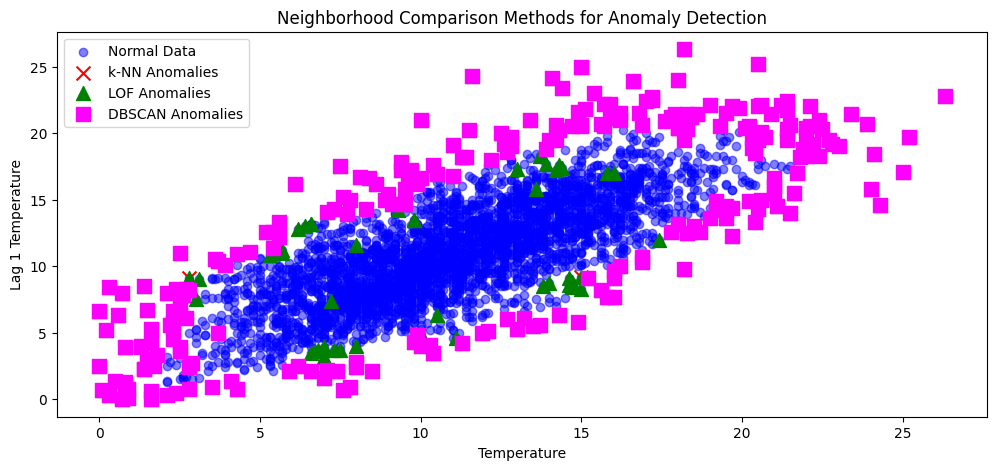

In [105]:
# ---- Visualization ----
plt.figure(figsize=(12,5))
plt.scatter(df_nn['Temp'], df_nn['Lag_1'], c='blue', label="Normal Data", alpha=0.5)
plt.scatter(df_nn[df_nn['knn_anomaly']]['Temp'], df_nn[df_nn['knn_anomaly']]['Lag_1'],
            color='red', label="k-NN Anomalies", marker='x', s=100)
plt.scatter(df_nn[df_nn['lof_anomaly']]['Temp'], df_nn[df_nn['lof_anomaly']]['Lag_1'],
            color='green', label="LOF Anomalies", marker='^', s=100)
plt.scatter(df_nn[df_nn['dbscan_anomaly']]['Temp'], df_nn[df_nn['dbscan_anomaly']]['Lag_1'],
            color='magenta', label="DBSCAN Anomalies", marker='s', s=100)
plt.xlabel("Temperature")
plt.ylabel("Lag 1 Temperature")
plt.title("Neighborhood Comparison Methods for Anomaly Detection")
plt.legend()
plt.show()